In [1]:
import numpy as np

import scipy as sc
import scipy.io as scio # for loading .mat file
from scipy import linalg
from scipy.spatial import KDTree

from sklearn.decomposition import PCA as PCAdimReduc
from sklearn.feature_extraction import DictVectorizer

import networkx as nx

import pygmtools as pygm

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

import cv2

import shapely

import svgpathtools
import drawsvg as draw

from bplustree import BPlusTree
from bplustree.serializer import Serializer
from bplustree.node import Node

import pickle

from xml.dom import minidom

import functools
from itertools import product, combinations
from typing import Optional, Tuple, List
from collections import Counter, defaultdict

import struct

import os, errno
import sys

import random

pygm.BACKEND = 'numpy' # set numpy as backend for pygmtools

# TOPOLOGY GRAPH / GEOMETRY EXTRACTION

In [2]:
from src.svg import *
from src.extraction import *
from src.database import *

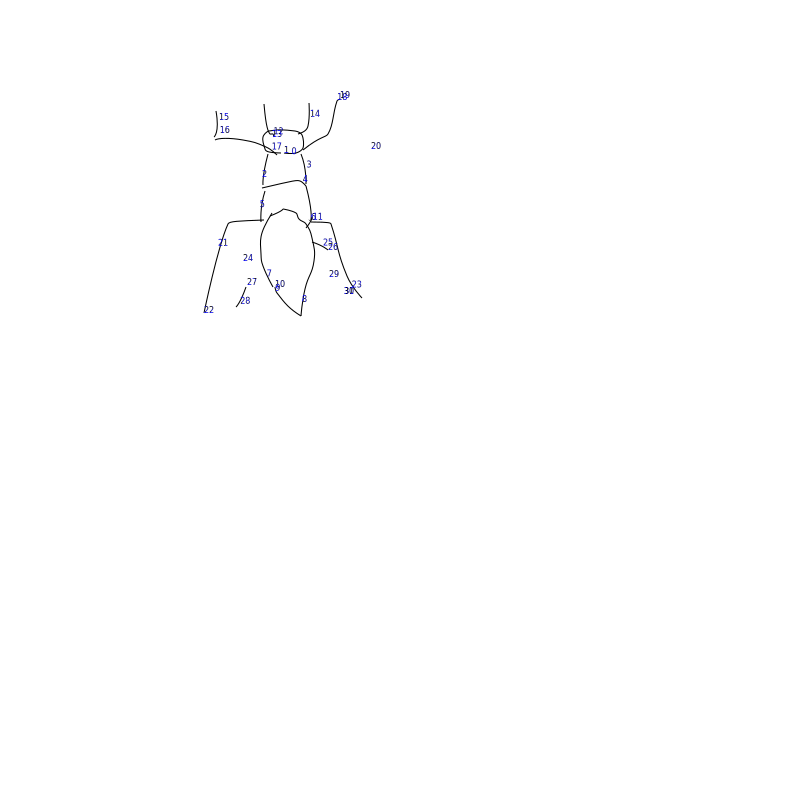

In [3]:
svg = load('assets/svg/ant/286.svg')
display(svg)

In [4]:
line_strings = get_line_strings(map(to_control_points, svg['paths']), step=15)

LINESTRING (270 150, 270 150, 270 150, 255 150, 255 150, 255 150, 255 150, 255 135, 255 135, 255 135, 255 135, 255 135, 255 135, 255 120, 255 120, 255 120, 255 120, 270 120, 270 120, 285 120, 285 120, 285 120, 300 120, 300 135, 300 135, 300 135, 300 135, 300 135, 300 135, 300 135, 285 150, 285 150, 285 150, 285 150, 270 150, 270 150)
<class 'shapely.geometry.linestring.LineString'>
141.21320343559643
0.0


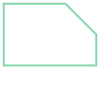

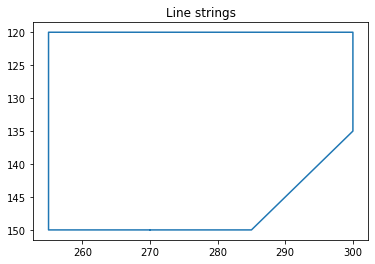

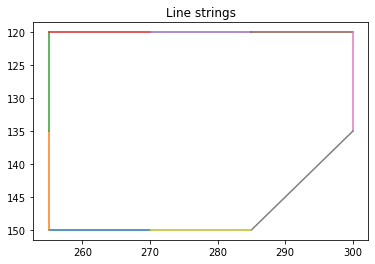

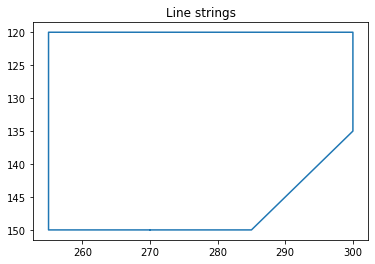

In [5]:
index = 0
ls = line_strings[index]

print(ls)
print(type(ls))
print(ls.length)

s, t = get_endpoints(ls)
print(s.distance(t))

plot_line_strings([ls])

segments = get_segments(ls)

# Plot segmented line string
plot_line_strings(segments)

# Plot closed line string
plot_line_strings([detect_approximate_polygon(ls)])

ls

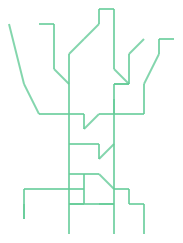

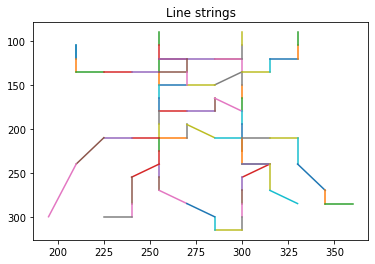

In [6]:
segments = []
for ls in line_strings:
    segments += get_segments(ls) 

# Plot segmented line string
plot_line_strings(segments)

shapely.MultiLineString(segments)

3


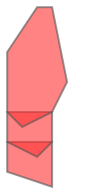

In [7]:
polygons = filter_polygons(get_polygons(line_strings), step=15)

print(len(polygons))

shapely.MultiPolygon(polygons)

### EXTRACTION

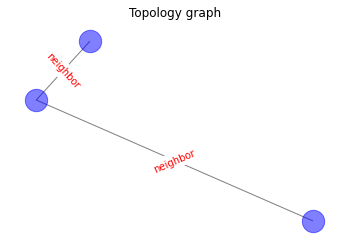

In [8]:
PATHS = map(to_control_points, svg['paths'])

G = extract_graph(PATHS, 'ant', step=15)
plot_graph(G)

G

# DATABASE

## Offline graph extraction

In [9]:
IMAGE_DIRECTORY = os.sep.join(['assets', 'svg'])

def load_svg_files(ext='svg'):
    """
    Returns an iterator that yields the image file paths and their labels.
    """    
    def get_label(path):
        return path.split(os.sep)[-1]
    
    files = []
    
    for r, _, f in os.walk(IMAGE_DIRECTORY):
        for file in f:
            if file.endswith(f'.{ext}'):
                label = get_label(r)
                file_path = os.path.join(r, file)
                
                files.append((file_path, label))
                
    return files


def load_svg_images(files):
    """
    Returns an iterator that yields the image data and their labels.
    """
    for f, l in files:
        print(f)
        yield load(f), l

def extract_graphs(images, step=20):
    """
    Extract all graphs from given images.
    """
    i = 0
    graphs = []
    for img, l in images:
        cp = map(to_control_points,img['paths'])
        
        try:
            graphs.append(extract_graph(cp, l, step=step))
        except StopIteration:
            print('drawing was too small')
        
        print(i)
        i += 1
        
    return graphs

In [10]:
# Extract graphs for each sketch in the dataset, offline processing step

# paths = load_svg_files()
# print(len(paths))

# images = load_svg_images(paths)

# graphs = extract_graphs(images, step=20)
# print(len(graphs))

In [11]:
import pickle

def dump_graphs(graphs, prefix=""):
    with open(prefix+'graphs.p', 'wb') as f:
        pickle.dump(graphs, f)
        
def load_graphs(prefix=""):
    with open(prefix+'graphs.p', 'rb') as f:
        return pickle.load(f)

In [12]:
# Dump the graphs to avoid this offline step later
# dump_graphs(graphs)

In [13]:
# Load graphs from disk
graphs = load_graphs()

len(graphs)

15564

## DIMENSIONALITY REDUCTION

max:  101
min:  0
99% percentile:  17.0


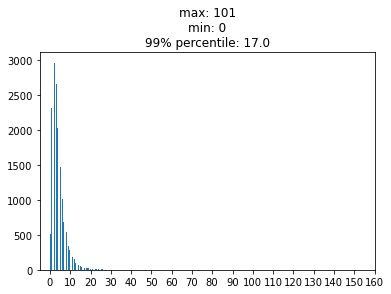

In [33]:
# Check the statistics for number of nodes

n = [len(g.nodes) for g in graphs]

fig = plt.figure()

# hist = np.histogram(n, bins=range(170))
plt.title(f'max: {max(n)}\nmin: {min(n)}\n99% percentile: {np.percentile(n, 99)}')
plt.hist(n, bins=170) #, density=True)

plt.xticks(np.arange(0, 170, step=10))

print('max: ', max(n))
print('min: ', min(n))
print('99% percentile: ', np.percentile(n, 99))

max:  2028
min:  0
99% percentile:  47.0


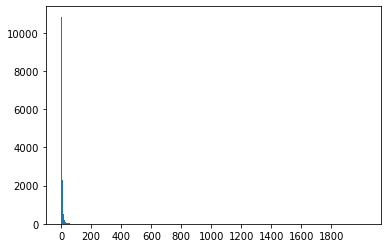

In [32]:
# Check the statistics for number of edges

e = [len(g.edges) for g in graphs]

# hist = np.histogram(e, bins=range(170))

fig = plt.figure()

plt.hist(e, bins=500) #, density=True)

plt.xticks(np.arange(0, 2000, step=200))

print('max: ', max(e))
print('min: ', min(e))
print('99% percentile: ', np.percentile(e, 99))

In [16]:
# Check descriptor collisions for a given descriptor length

maximum = max(n)

print('100th percentile (maximum): ', maximum )

descriptors_max = [descriptor(g, N=maximum).tobytes() for g in graphs]

c_max = Counter(descriptors_max)

print('Unique descriptors: ', list(c_max.values()).count(1))

[(np.frombuffer(d, dtype=float), c) for d, c in c_max.most_common()]

100th percentile (maximum):  101
Unique descriptors:  3114


[(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  3715),
 (array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  2969),
 (array([1.41421356e+00, 1.41421356e+00, 2.77516890e-17, 0.000

In [37]:
# Check descriptor collisions for a given descriptor length

import pandas as pd

percent = 84

percentile = int(np.percentile(n,percent))

print(f'{percent}th percentile: ', percentile)

descriptors = [descriptor(g, N=percentile).tobytes() for g in graphs]

c_percentile = Counter(descriptors)

print('Unique descriptors: ', list(c_percentile.values()).count(1))

data = [(np.frombuffer(d, dtype=float), c) for d, c in c_percentile.most_common()]

df = pd.DataFrame(data, columns =['Descriptor', 'Counts'])
df

84th percentile:  7
Unique descriptors:  3114


Descriptor  Counts
0                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]    3715
1                   [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]    2969
2     [1.4142135623730954, 1.4142135623730951, 2.775...     958
3     [1.9999999999999996, 1.0, 0.9999999999999999, ...     859
4     [1.4142135623730951, 1.414213562373095, 0.0, 0...     540
...                                                 ...     ...
3478  [2.3455198572758245, 1.8595812127072666, 1.618...       1
3479  [3.4438959399100098, 2.923060905780924, 2.1741...       1
3480  [3.4301831477144753, 2.6554423815498294, 2.161...       1
3481  [4.361303610506675, 2.7937532591185676, 2.0828...       1
3482  [2.414213562373094, 1.7320508075688772, 1.7320...       1

[3483 rows x 2 columns]

### Derive the frequencies of each label per descriptor

In [18]:
from src.labels import LABELS
len(LABELS)

250

In [19]:
# Get the weights of all categories 

# Filter graphs to a subset of labels if wanted
graphs = graphs

descriptors = map(lambda g: descriptor(g, N=7).tobytes(), graphs)

labels = map(lambda g: g.graph['label'], graphs)

res = defaultdict(list)
for key, val in zip(descriptors, labels):
    res[key].append(val)
    
counts = {k: Counter(v) for k, v in res.items()}
counts

{b"O\x92\x0cuN\xbe\x02@\x0f\x00\x8b@\x88\x04\xfd?\xff\xff\xff\xff\xff\xff\xef?\xb4m\xc7Y\xad\x1f\xde?\x99\xa9\xf2'\xd1\xf1f<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00": Counter({'airplane': 1,
          'backpack': 3,
          'bee': 2,
          'bell': 1,
          'bicycle': 1,
          'brain': 1,
          'bulldozer': 1,
          'castle': 1,
          'cat': 1,
          'frog': 1,
          'hand': 1,
          'head-phones': 1,
          'hedgehog': 1,
          'horse': 2,
          'hourglass': 1,
          'owl': 1,
          'pickup truck': 1,
          'rabbit': 2,
          'rainbow': 1,
          'satellite': 1,
          'scissors': 1,
          'shark': 1,
          'sheep': 1,
          'tiger': 1,
          'tractor': 2}),
 b'\xcd;\x7ff\x9e\xa0\xf6?\xcc;\x7ff\x9e\xa0\xf6?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00': Counter({'

In [20]:
# Vectorize these frequencies

to_index = {label: i for i, label in enumerate(LABELS)}

def get_frequencies(descriptor, counter):
    freq = np.zeros(len(LABELS), dtype=np.int8)
    
    for label, count in counter.items():
        i = to_index[label]
        freq[i] = count
        
    # freq /= np.sum(freq)
    return freq

FREQUENCIES = {d: get_frequencies(d, c).tobytes() for d, c in counts.items()}
FREQUENCIES  

{b"O\x92\x0cuN\xbe\x02@\x0f\x00\x8b@\x88\x04\xfd?\xff\xff\xff\xff\xff\xff\xef?\xb4m\xc7Y\xad\x1f\xde?\x99\xa9\xf2'\xd1\xf1f<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00": b'\x01\x00\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x02\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x01\x00\x00\x02\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x01\x00\x00\x00\x00\x00\x00\x01\x00\x00\x01\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [21]:
# Dump frequencies

def dump_frequencies():
    with open('frequencies.p', 'wb') as f:
        pickle.dump(FREQUENCIES , f)

def load_frequencies():
    with open('frequencies.p', 'rb') as f:
        return pickle.load(f)
        
dump_frequencies()

In [22]:
# Check the frequencies for the zero descriptor
f = FREQUENCIES[bytes(8*7)]
np.frombuffer(f, dtype=np.int8)

array([22,  9,  5,  9, 39, 55,  5,  2, 16,  3, 21,  6, 39,  3, 11, 27,  9,
        2,  3, 12, 17,  9,  7, 17,  2,  2, 41,  7, 10,  7, 12, 12,  5,  4,
       39,  7,  7, 28,  2,  6, 43,  2, 10,  5, 15,  6, 34,  4, 12,  1, 12,
       21, 16, 20, 55, 23,  9,  7,  6, 21, 21, 11, 36, 16,  2,  6, 22, 33,
        4, 16, 14, 18, 26, 16, 22,  8,  4, 42, 27, 14, 17,  9, 18, 13, 36,
       14, 26,  6, 27, 21, 20,  6, 37, 19,  1, 18,  2, 12, 30,  1,  9, 20,
       36, 18,  8,  3, 25,  5,  3,  6,  6, 40,  5,  9, 30,  8, 11,  6,  4,
        2, 17, 20,  8,  6, 20,  5, 14, 12, 10, 24, 11, 13, 42, 20,  6, 29,
        4,  4, 17, 15,  5,  9, 25,  6,  5,  2,  5, 16, 51, 11, 13, 12, 19,
        4,  6, 23, 26,  7, 19,  4, 20, 11,  2,  0, 12,  4, 15,  9,  3, 25,
       13, 19, 11, 24, 17,  4,  6,  8, 17, 17, 25, 12,  6, 25, 32, 20, 11,
        9, 33, 29, 16, 10,  1, 33, 14,  1, 18,  4, 11, 23, 13, 22, 16, 19,
        7, 14, 46, 21, 12, 58,  1, 29, 32, 20, 54, 19, 23,  2,  6,  5,  2,
       14, 12,  8,  1,  2

## Database construction

### Disk B+-tree mapping descriptors to graph data

In [23]:
FREQUENCIES = load_frequencies()

In [24]:
# # Create iterator for all key/value pairs to be inserted into database
# iterator = sorted(FREQUENCIES.items(), key=lambda p: p[0])

# # Construct database for online use
# db = construct_database(iterator, N=7, value_size=250)

[1. 1. 0. 0. 0. 0. 0.]


'panda'

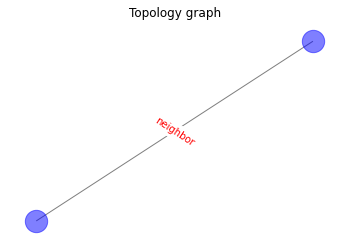

In [25]:
# Test query
db = open_database()

svg = load('assets/svg/ant/279.svg')

paths = map(to_control_points, svg['paths'])

query = extract_graph(paths, 'ant')
plot_graph(query)

key = descriptor(query, N=DESCRIPTOR_SIZE)
print(key)

dist = query_database(db, query)

db.close()

i = np.argmax(dist)
LABELS[i]

# Evaluation

In [45]:
IMAGE_DIRECTORY = os.sep.join(['assets', 'svg'])

def load_first_svg_files(ext='svg'):
    """
    Returns an iterator that yields the image file paths and their labels.
    """    
    files = []
    
    dirs = next(os.walk(IMAGE_DIRECTORY))[1]
    for d in dirs:
        dir_path = os.path.join(IMAGE_DIRECTORY, d)
        
        for i in range(5):
            file = os.listdir(dir_path)[i]
            file = os.path.join(dir_path, file)

            files.append((file, d))
                
    return files

def extract_graphs(images, step=20):
    """
    Extract all graphs from given images.
    """
    i = 0
    graphs = []
    for img, l in images:
        cp = map(to_control_points,img['paths'])
        
        try:
            graphs.append(extract_graph(cp, l, step=step, check_area=False))
        except StopIteration:
            print('drawing was too small')
        
        print(i)
        i += 1
        
    return graphs


In [47]:


paths = load_first_svg_files()
print(len(paths))

images = load_svg_images(paths)

graphs = extract_graphs(images, step=20)
print(len(graphs))

db = open_database()



1250
assets\svg\airplane\1.svg
0
assets\svg\airplane\10.svg
1
assets\svg\airplane\11.svg
2
assets\svg\airplane\12.svg
3
assets\svg\airplane\13.svg
4
assets\svg\alarm clock\100.svg
5
assets\svg\alarm clock\101.svg
6
assets\svg\alarm clock\102.svg
7
assets\svg\alarm clock\103.svg
8
assets\svg\alarm clock\104.svg
9
assets\svg\angel\161.svg
10
assets\svg\angel\162.svg
11
assets\svg\angel\163.svg
12
assets\svg\angel\164.svg
13
assets\svg\angel\165.svg
14
assets\svg\ant\241.svg
15
assets\svg\ant\242.svg
16
assets\svg\ant\243.svg
17
assets\svg\ant\244.svg
18
assets\svg\ant\245.svg
19
assets\svg\apple\321.svg
20
assets\svg\apple\322.svg
21
assets\svg\apple\323.svg
22
assets\svg\apple\324.svg
23
assets\svg\apple\325.svg
24
assets\svg\arm\401.svg
25
assets\svg\arm\402.svg
26
assets\svg\arm\403.svg
27
assets\svg\arm\404.svg
28
assets\svg\arm\405.svg
29
assets\svg\armchair\481.svg
30
assets\svg\armchair\482.svg
31
assets\svg\armchair\483.svg
32
assets\svg\armchair\484.svg
33
assets\svg\armchair\48

AssertionError: 

In [48]:
from src.svg import *
from src.extraction import *
from src.database import *

[2.34292308e+00 1.81360650e+00 1.00000000e+00 4.70683420e-01
 9.95063308e-18 0.00000000e+00 0.00000000e+00]
bridge
[1.41421356 1.41421356 0.         0.         0.         0.
 0.        ]
panda
[0. 0. 0. 0. 0. 0. 0.]
panda
[0. 0. 0. 0. 0. 0. 0.]
panda
[1.73205081 1.73205081 0.         0.         0.         0.
 0.        ]
panda
[2.17008649 1.4811943  1.         0.31110782 0.         0.
 0.        ]
panda
[0. 0. 0. 0. 0. 0. 0.]
panda
[3.40368189 1.86190973 1.28269614 1.         0.48972682 0.25119717
 0.        ]
wheelbarrow
[2.17008649 1.4811943  1.         0.31110782 0.         0.
 0.        ]
panda
[2.56155281e+00 1.56155281e+00 1.00000000e+00 2.32333399e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
camera
[3.46793236e+00 2.00000000e+00 1.58180720e+00 9.12754966e-01
 7.98880130e-01 1.49781195e-17 0.00000000e+00]
wheelbarrow
[3.32895753 2.38187168 1.77898854 1.54453568 1.         0.72499294
 0.37432428]
santa claus
[1.41421356 1.41421356 0.         0.         0.         0.
 0.     

d:\sketcher\src\extraction.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


panda
[0. 0. 0. 0. 0. 0. 0.]
panda
[0. 0. 0. 0. 0. 0. 0.]
panda
[0. 0. 0. 0. 0. 0. 0.]
panda
[0. 0. 0. 0. 0. 0. 0.]
panda
[1. 1. 0. 0. 0. 0. 0.]
panda
[0. 0. 0. 0. 0. 0. 0.]
panda
[0. 0. 0. 0. 0. 0. 0.]
panda
[0. 0. 0. 0. 0. 0. 0.]
panda
[0. 0. 0. 0. 0. 0. 0.]
panda
[0. 0. 0. 0. 0. 0. 0.]
panda
[4.69840629 2.38387831 2.09330419 1.76193694 1.42321056 1.24903623
 1.        ]
pineapple
[2.68554393e+00 1.74911755e+00 1.27133037e+00 3.34903985e-01
 1.78257134e-33 0.00000000e+00 0.00000000e+00]
camera
[2.17008649 1.4811943  1.         0.31110782 0.         0.
 0.        ]
panda
[1.41421356 1.41421356 0.         0.         0.         0.
 0.        ]
panda
[2. 1. 1. 0. 0. 0. 0.]
panda
[2.68554393e+00 1.74911755e+00 1.27133037e+00 3.34903985e-01
 2.72877821e-18 0.00000000e+00 0.00000000e+00]
camera
[3. 1. 1. 1. 0. 0. 0.]
wheelbarrow
[4. 1. 1. 1. 1. 0. 0.]
bulldozer
[5.07674401 2.32035636 2.03745389 1.94557224 1.67366124 1.53714736
 1.4567719 ]
suv
[1. 1. 0. 0. 0. 0. 0.]
panda
[0. 0. 0. 0. 0. 0.

KeyboardInterrupt: 

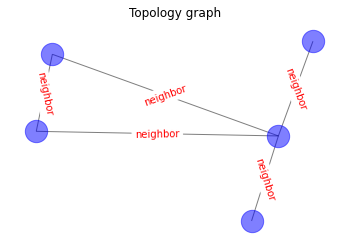

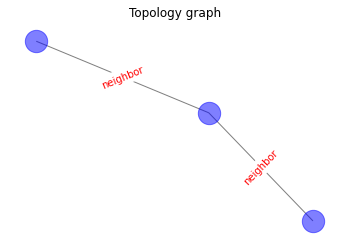

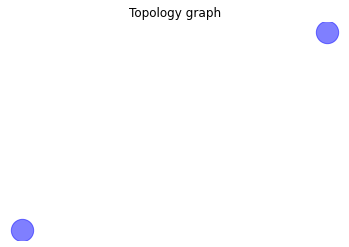

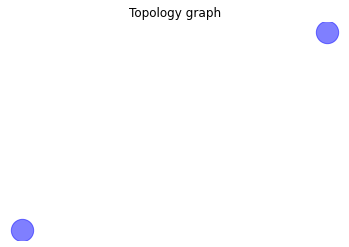

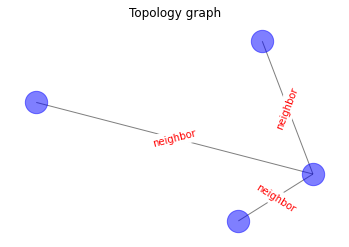

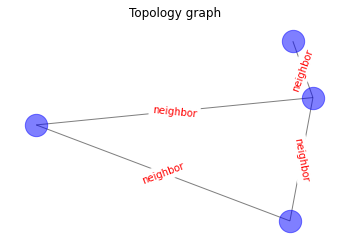

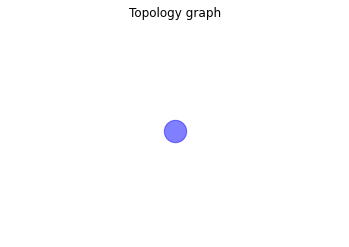

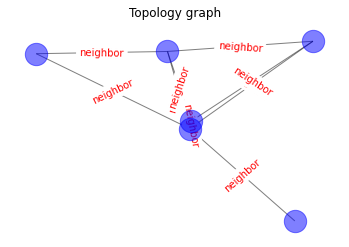

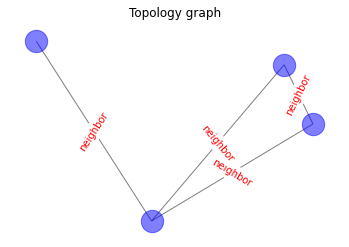

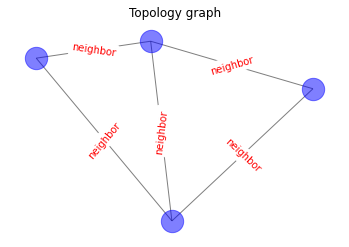

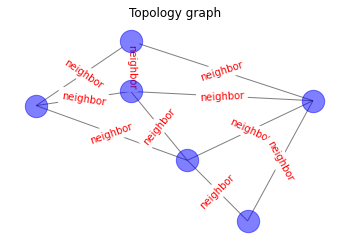

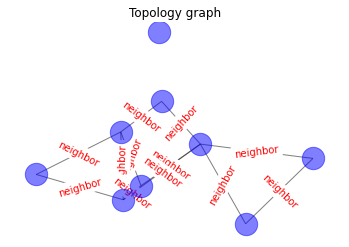

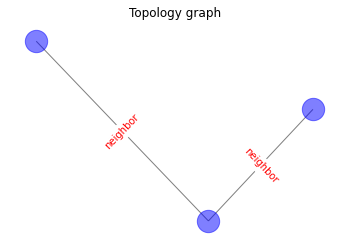

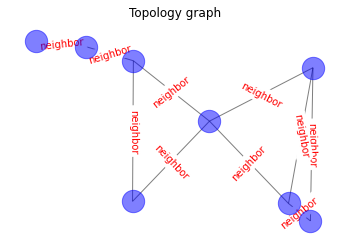

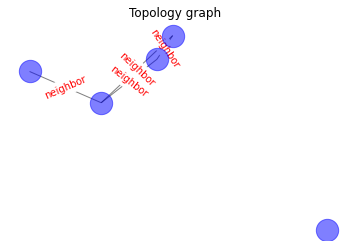

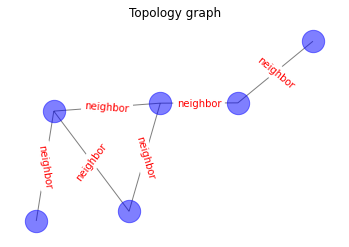

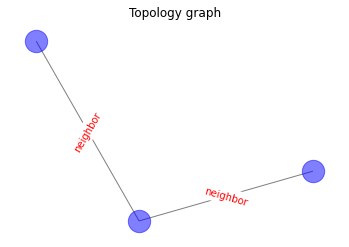

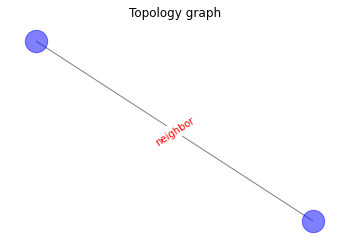

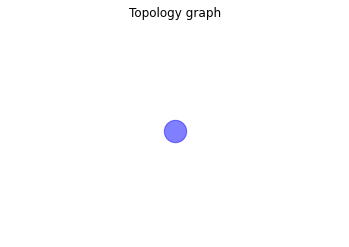

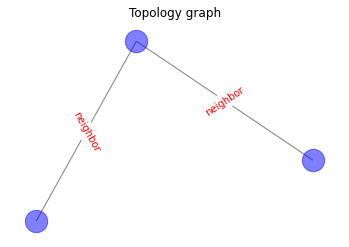

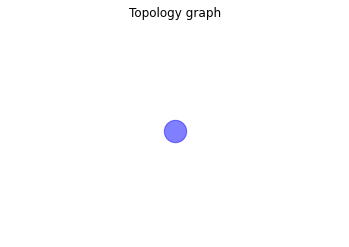

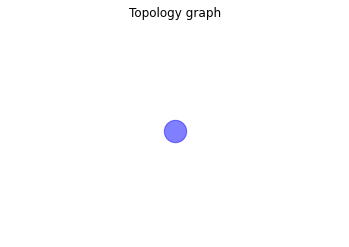

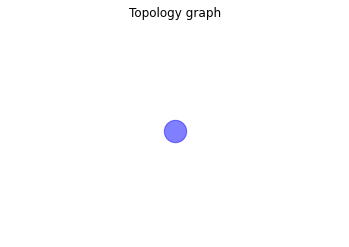

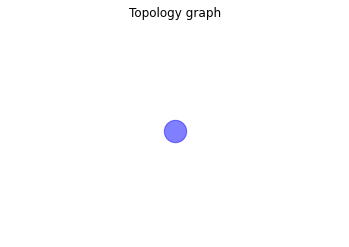

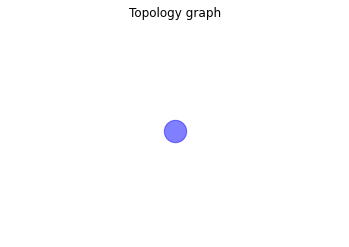

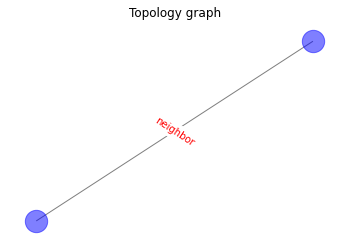

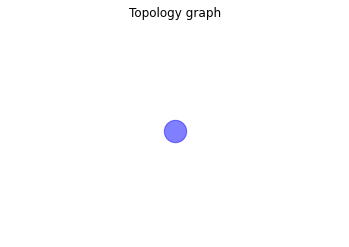

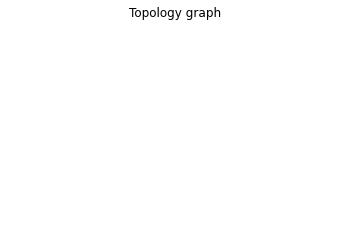

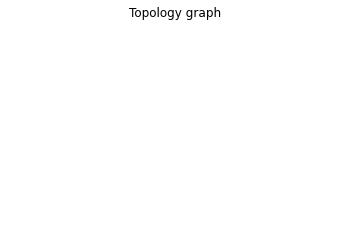

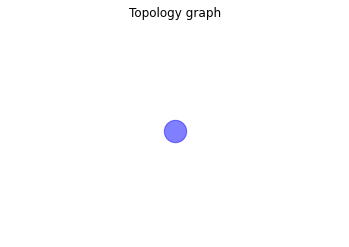

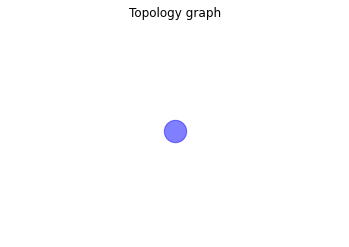

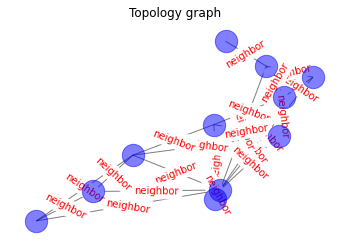

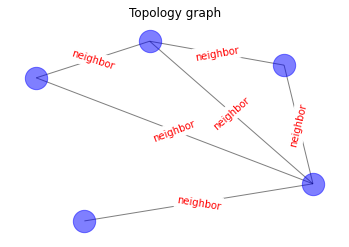

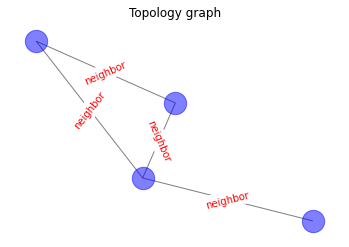

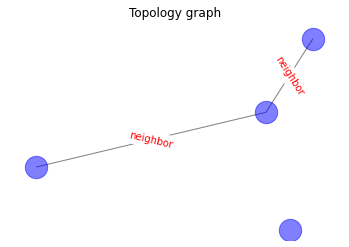

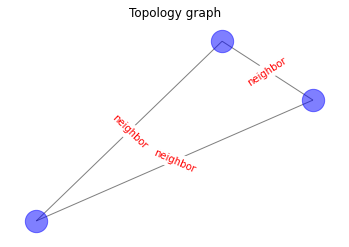

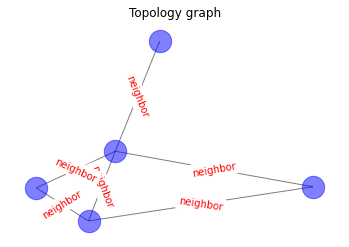

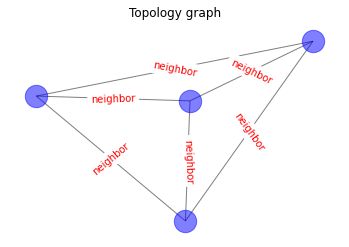

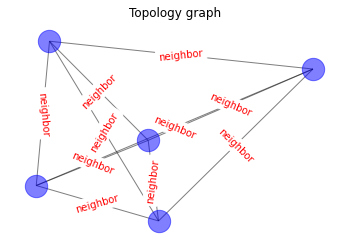

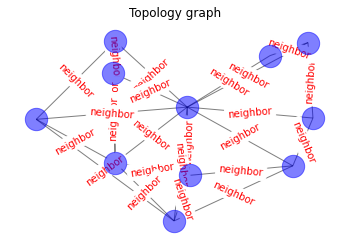

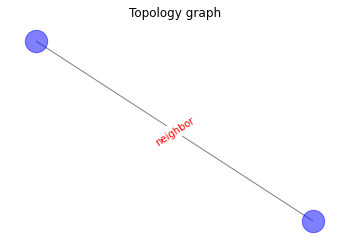

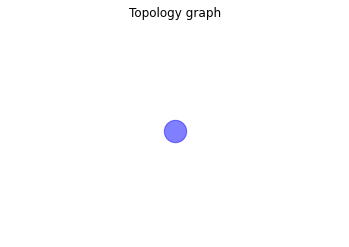

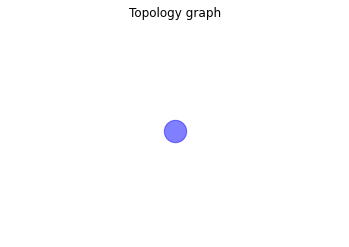

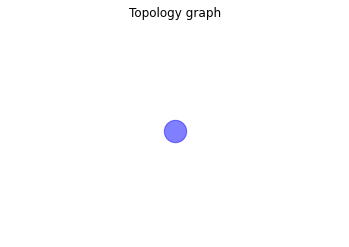

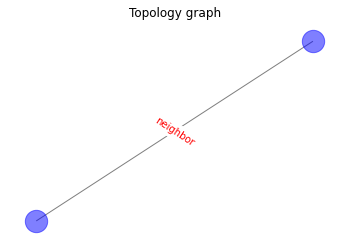

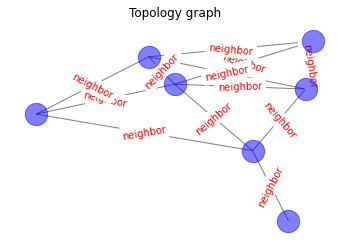

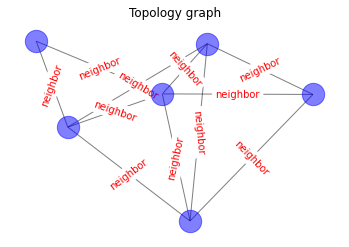

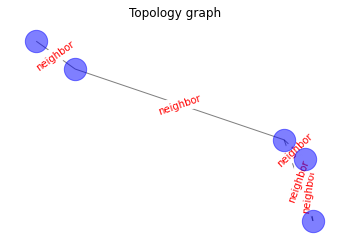

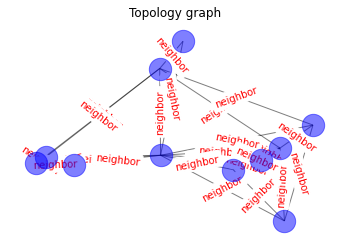

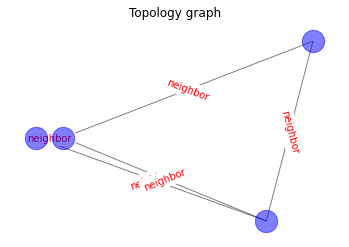

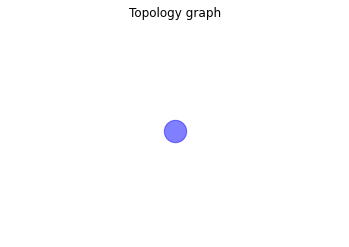

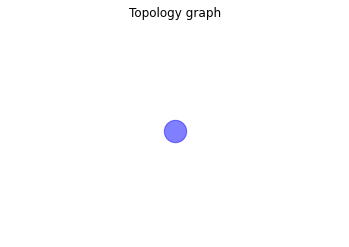

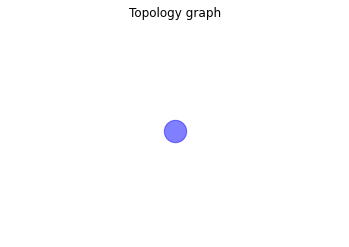

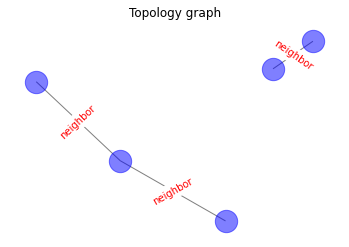

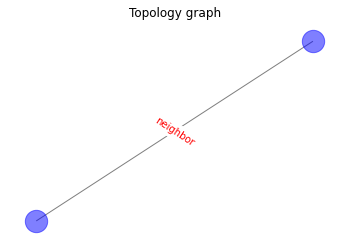

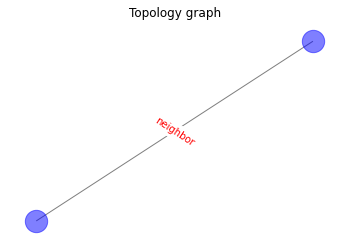

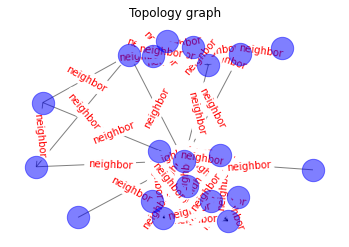

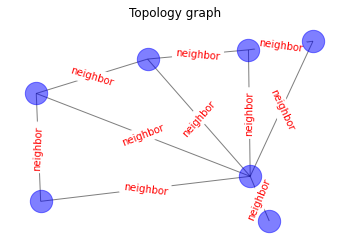

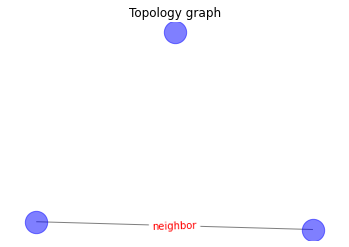

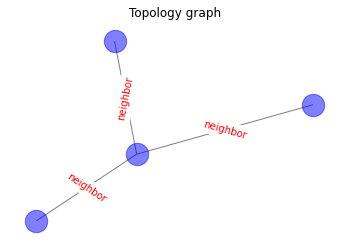

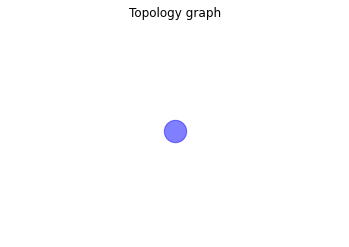

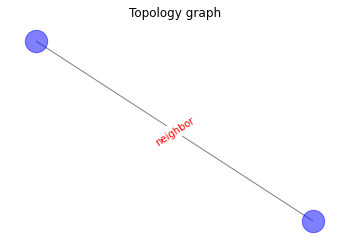

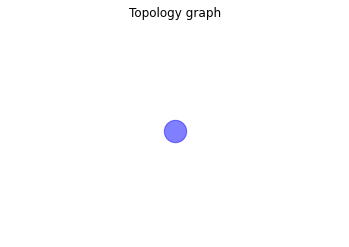

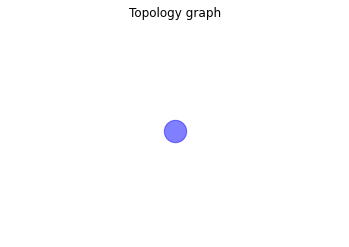

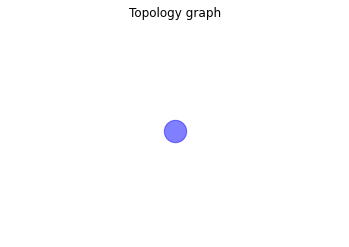

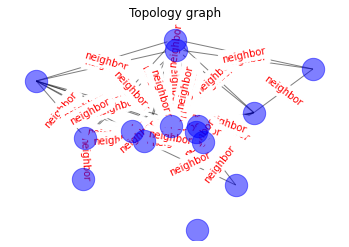

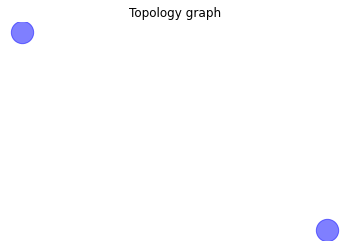

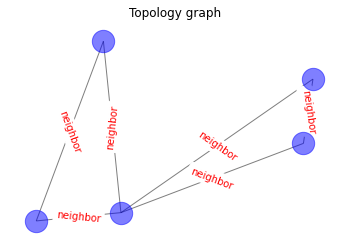

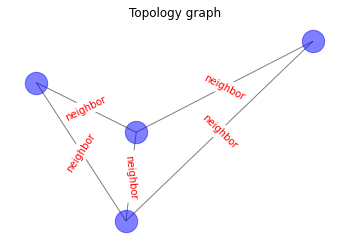

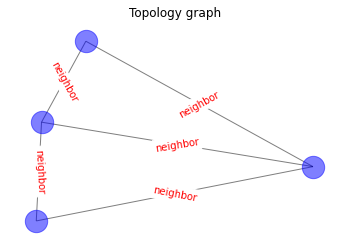

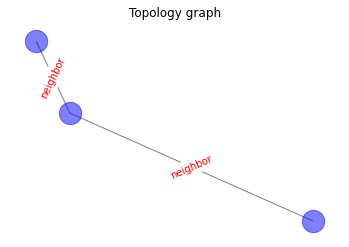

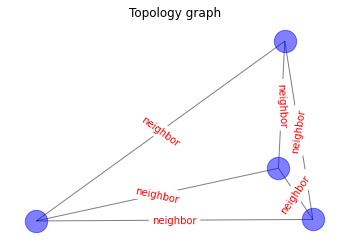

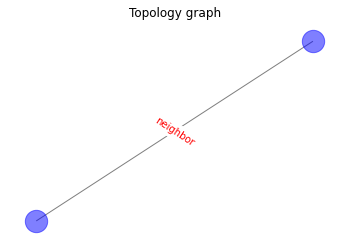

In [49]:
dists = []

for i, query in enumerate(graphs):
    key = descriptor(query, N=DESCRIPTOR_SIZE)
    print(key)

    dist = query_database(db, query)

    dists.append(dist)

    i = np.argmax(dist)
    print(LABELS[i])

    # # Figure Size
    # fig = plt.figure()

    # plt.suptitle(f"file: {paths[i]}\nargmax: {LABELS[i]}")
    
    # # Horizontal Bar Plot
    # plt.bar(range(len(LABELS)), dist)
    # plt.xticks(range(0, len(LABELS), len(LABELS)//10))

    # plt.show()

close_database(db)